# ROME - example


<br />

for each unique pair of contiguous convective regions (objects), a, b, in a scene:
<br />

$ROME_{pair} = A_{a} + \text{min}(1, \: \frac{A_{b}}{A_{d}}) \cdot A_b$
<br />
\
Where: \
$A_{a}$ - area of larger object of pair \
$A_{b}$ - area of smaller object of pair \
$A_{d}$ - shortest distance between the two objects, squared

<br />

$ROME = \Biggl\{ 
\begin{matrix}
\frac{1}{k} \cdot \sum_{i=1}^{k} ROME_{pair(i)} & n>1\\
A_{a} & n=1
\end{matrix}$
<br />

Where: \
$k$ - number of unique pairs in a scene

<br />


Essentially the pairs are the added areas, unless the distance between the objects is larger than the effective square side of the smaller object. \
In that case the contribution from the smaller area to the pair value is modulated (which would be most of the time for our scenes)

In [6]:
import xarray as xr

import numpy as np
import skimage.measure as skm

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeat

import os

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import myPlots
import myFuncs

import aggFuncs
import pandas as pd

ModuleNotFoundError: No module named 'myPlots'

## convective regions from precipitation fields

### from local

In [3]:
model = 'GFDL-CM3'
experiment = 'historical'
folder = '/Users/cbla0002/Documents/data/cmip5/' + model

In [4]:
fileName = model + '_pr4_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)

In [5]:
ds

<xarray.Dataset>
Dimensions:   (time: 4, lat: 22, lon: 128)
Coordinates:
  * time      (time) object 1970-01-01 12:00:00 ... 1970-01-04 12:00:00
  * lat       (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 23.72 26.51 29.3
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr4_days  (time, lat, lon) float32 ...

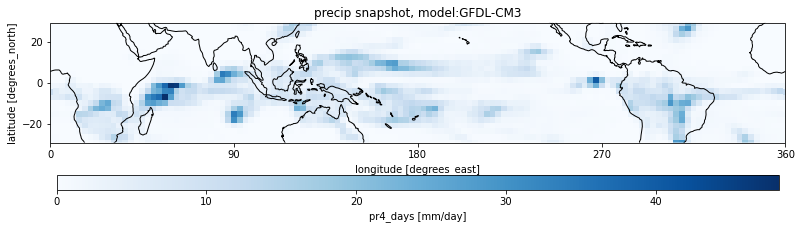

In [6]:
myPlots.plot_snapshot(ds.pr4_days.isel(time=0), 'Blues', 'precip', model)

In [7]:
fileName = model + '_pr_extreme_' + experiment + '.nc'
path = folder + '/' + fileName
ds_percentile = xr.open_dataset(path)

In [8]:
ds_percentile

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    pr_97    (time) float64 ...
    pr_99    (time) float64 ...
    pr_999   (time) float64 ...

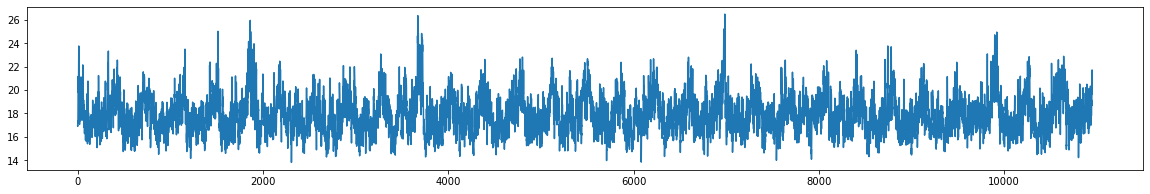

In [9]:
plt.figure(figsize= (20,3))
plt.plot(ds_percentile.pr_97.data)

In [10]:
pr_day = ds.pr4_days.isel(time=0)

In [11]:
# label 8-connected (2-connectivity) objects
conv_threshold = ds_percentile.pr_97.mean(dim=('time'))
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero is necessary to turn pr values to True/False
myFuncs.connect_boundary(L)

In [12]:
L_xr = xr.DataArray(
    data=L,
    dims=['lat', 'lon'],
    coords={'lat': pr_day.lat.data, 'lon': pr_day.lon.data}
    )

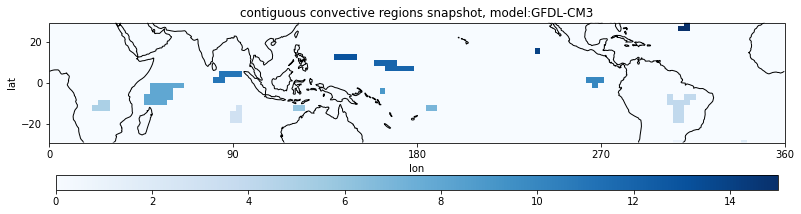

In [13]:
myPlots.plot_snapshot(L_xr, 'Blues', 'contiguous convective regions', model)

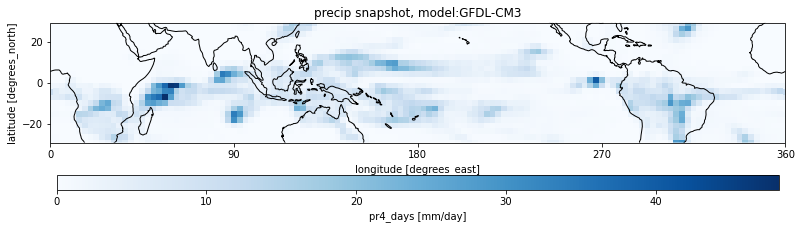

In [14]:
# for comparison
myPlots.plot_snapshot(ds.pr4_days.isel(time=0), 'Blues', 'precip', model)

## ROME

$ROME_{pair} = A_{a} + \text{min}(1, \: \frac{A_{b}}{A_{d}}) \cdot A_b$

In [15]:
# scene to calculate rome from
pr_day = ds.pr4_days.isel(time=0)
conv_threshold = ds_percentile.pr_97.mean(dim=('time'))
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero turns pr values to True/False
myFuncs.connect_boundary(L)

labels = np.unique(L)[1:]
print(labels)
print(len(labels))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
15


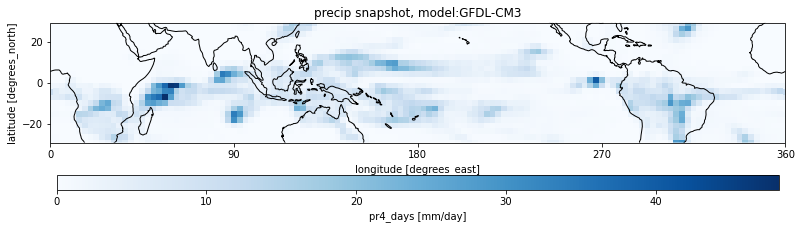

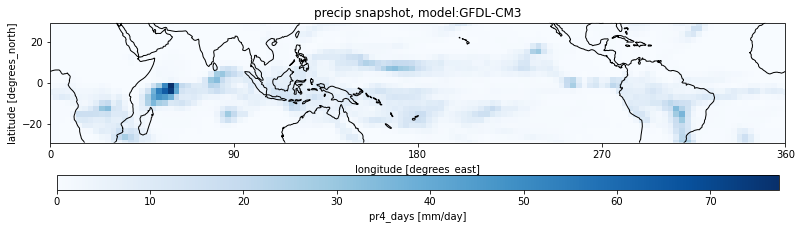

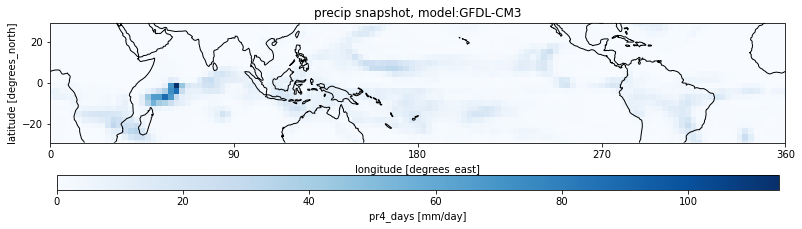

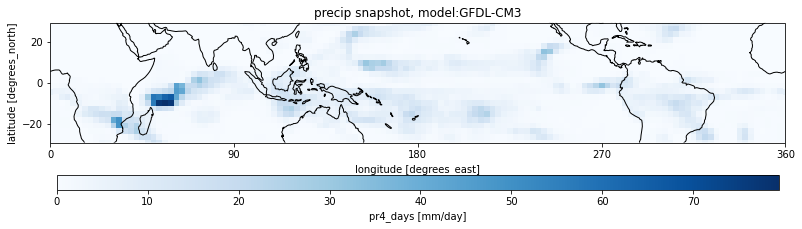

In [16]:
# see all scenes
for day in np.arange(0,4):
    pr_day = ds.pr4_days.isel(time=day)
    myPlots.plot_snapshot(pr_day, 'Blues', 'precip', model)

In [17]:
# dimensions used for calculation
lat = pr_day.lat.data
lon = pr_day.lon.data
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
lonm3d = np.expand_dims(lonm,axis=2)
aream3d = np.expand_dims(aream,axis=2) # (used later for n largest)
shape_L = np.shape(L)

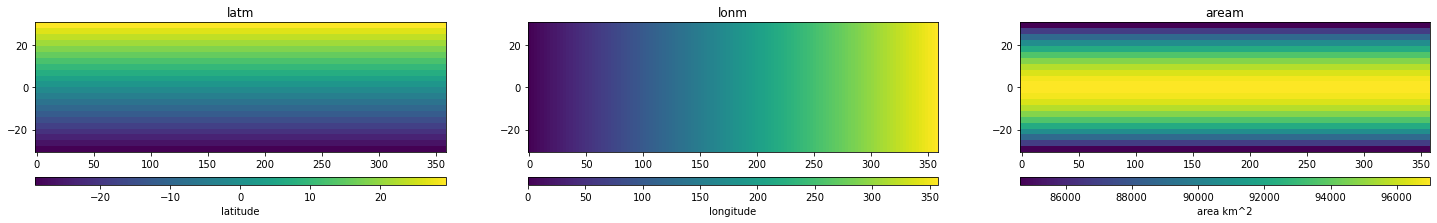

In [18]:
# see dimension matrices
f, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (25,3))

p1 = ax1.pcolormesh(lon, lat, latm)
ax1.set_title('latm')
plt.colorbar(p1, ax=ax1, orientation='horizontal',pad=0.15, aspect=50, fraction=0.055,  label = 'latitude') 

p2 = ax2.pcolormesh(lon, lat, lonm)
ax2.set_title('lonm')
plt.colorbar(p2, ax=ax2, orientation='horizontal',pad=0.15, aspect=50, fraction=0.055, label = 'longitude') 

p3 = ax3.pcolormesh(lon, lat, aream)
ax3.set_title('aream')
plt.colorbar(p3, ax=ax3, orientation='horizontal',pad=0.15, aspect=50, fraction=0.055, label = 'area km^2')  

In [30]:
# calculation for one scene
rome_allPairs = []

if len(labels) ==1:
    rome_allPairs = np.sum((L==labels)*1 * aream)

else:
    for idx, labeli in enumerate(labels[0:-1]):
        
        # find coordinates of object i
        I, J = zip(*np.argwhere(L==labeli))
        I = list(I)
        J = list(J)

        # area of object i
        oi_area = np.sum(aream[I,J])

        # shortest distance from object i, start by counting the number of gridboxes in object
        Ni = len(I)

        # replicate each gridbox lon and lat into Ni 2D slices with the shape of L
        lati3d = np.tile(lat[I],reps =[shape_L[0], shape_L[1], 1])
        loni3d = np.tile(lon[J],reps =[shape_L[0], shape_L[1], 1])


        # create corresponding 3D matrix from Ni copies of latm, lonm (this metrix only needs to be recreated when Ni increases from previous loop)
        if Ni > np.shape(lonm3d)[2]:
            latm3d = np.tile(latm3d[:,:,0:1],reps =[1, 1, Ni])
            lonm3d = np.tile(lonm3d[:,:,0:1],reps =[1, 1, Ni])


        # distance from gridboxes of object i to every other point in the domain
        distancei3d = myFuncs.haversine_dist(lati3d,loni3d,latm3d[:,:,0:Ni],lonm3d[:,:,0:Ni])

        # minimum in the third dimension gives shortest distance from object i to every other point in the domain
        distancem = np.amin(distancei3d, axis=2)
 
        # the shortest distance from object i to object j will be the minimum of the coordinates of object j in distancem
        for labelj in labels[idx+1:]:

            # coordinates of object j
            I, J = zip(*np.argwhere(L==labelj))

            # area of object j
            oj_area = np.sum(aream[I,J])

            # ROME of unique pair
            large_area = np.maximum(oi_area, oj_area)
            small_area = np.minimum(oi_area, oj_area)
            rome_pair = large_area + np.minimum(small_area, (small_area/np.amin(distancem[I,J]))**2)
            rome_allPairs = np.append(rome_allPairs, rome_pair)

In [31]:
len(rome_allPairs)

105

In [34]:
rome_allPairs[0:3]

array([ 170052.48066566,  466482.91902832, 1251144.92156784])

In [35]:
np.mean(rome_allPairs)

739821.2112164496

In [36]:
# as function
def rome_scene(L, labels, lat, lon, aream, latm3d, lonm3d):
    rome_allPairs = []
    shape_L = np.shape(L)
    
    if len(labels) ==1:
        rome_allPairs = np.sum((L==labels)*1 * aream)

    else:
        for idx, labeli in enumerate(labels[0:-1]):
            
            # find coordinates of object i
            I, J = zip(*np.argwhere(L==labeli))
            I = list(I)
            J = list(J)

            # area of object i
            oi_area = np.sum(np.squeeze(aream)[I,J])

            # shortest distance from object i, start by counting the number of gridboxes
            Ni = len(I)

            # replicate each gridbox lon and lat into Ni 2D slices with the shape of L
            lati3d = np.tile(lat[I],reps =[shape_L[0], shape_L[1], 1])
            loni3d = np.tile(lon[J],reps =[shape_L[0], shape_L[1], 1])


            # create corresponding 3D matrix from Ni copies of latm, lonm (this metrix only needs to be recreated when Ni increases from previous loop)
            if Ni > np.shape(lonm3d)[2]:
                lonm3d = np.tile(lonm3d[:,:,0:1],reps =[1, 1, Ni])
                latm3d = np.tile(latm3d[:,:,0:1],reps =[1, 1, Ni])


            # distance from gridboxes of object i to every other point in the domain
            distancei3d = myFuncs.haversine_dist(lati3d,loni3d,latm3d[:,:,0:Ni],lonm3d[:,:,0:Ni])

            # minimum in the third dimension gives shortest distance from object i to every other point in the domain
            distancem = np.amin(distancei3d, axis=2)
    
    
            # the shortest distance from object i to object j will be the minimum of the coordinates of object j in distancem
            for labelj in labels[idx+1:]:

                # coordinates of object j
                I, J = zip(*np.argwhere(L==labelj))

                # area of object j
                oj_area = np.sum(aream[I,J])

                # ROME of unique pair
                large_area = np.maximum(oi_area, oj_area)
                small_area = np.minimum(oi_area, oj_area)
                rome_pair = large_area + np.minimum(small_area, (small_area/np.amin(distancem[I,J]))**2)
                rome_allPairs = np.append(rome_allPairs, rome_pair)
                
    return np.mean(rome_allPairs)



In [37]:
rome_scene(L, labels, lat, lon, aream, latm3d, lonm3d)

739821.2112164496

$ROME = \Biggl\{ 
\begin{matrix}
\frac{1}{k} \cdot \sum_{i=1}^{k} ROME_{pair(i)} & n>1\\
A_{a} & n=1
\end{matrix}$

In [44]:
# calculation for multiple scenes
rome = []
listOfdays = np.arange(0,len(ds.pr4_days.time))
precip = ds.pr4_days

for day in listOfdays:
    pr_day = precip.isel(time=day)
    L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2)
    myFuncs.connect_boundary(L)

    labels = np.unique(L)[1:]

    rome = np.append(rome, rome_scene(L, labels, lat, lon, aream, latm3d, lonm3d))
            

In [45]:
len(rome)

4

In [46]:
rome

array([ 739821.21121645,  937456.68634992, 1044404.23990335,
        986752.67239723])

In [50]:
# as function
def calc_rome(precip, listOfdays, conv_threshold):
    rome = []

    lat = precip.lat.data
    lon = precip.lon.data
    lonm,latm = np.meshgrid(lon,lat)
    dlat = (lat[1]-lat[0])
    dlon = (lon[1]-lon[0])
    R = 6371
    aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

    latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
    lonm3d = np.expand_dims(lonm,axis=2)
    aream3d = np.expand_dims(aream,axis=2) # (usef later for n largest)    


    for day in listOfdays:
        pr_day = precip.isel(time=day)
        L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero turns ones and zeros to True/False
        myFuncs.connect_boundary(L)
        
        labels = np.unique(L)[1:]

        rome = np.append(rome, rome_scene(L, labels, lat, lon, aream, latm3d, lonm3d))
    
    rome = xr.DataArray(
        data=rome,
        dims=['time'],
        coords={'time': precip.time.data[0:len(listOfdays)]},
        attrs={'units':'km^2'}
        )

    return rome


In [24]:
# calling on data array
precip = ds.pr4_days
listOfdays = np.arange(0,len(ds.pr4_days.time))

calc_rome(precip, listOfdays, conv_threshold)


## ROME n largest

In [52]:
# scene to calculate rome from (same as before)
pr_day = ds.pr4_days.isel(time=0)
conv_threshold = ds_percentile.pr_97.mean(dim=('time'))
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero turns ones and zeros to True/False
myFuncs.connect_boundary(L)

labels = np.unique(L)[1:]
print(labels)
print(len(labels))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
15


In [54]:
# dimensions again (same as before)
lat = pr_day.lat.data
lon = pr_day.lon.data
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
lonm3d = np.expand_dims(lonm,axis=2)
aream3d = np.expand_dims(aream,axis=2) # (usef later for n largest)
shape_L = np.shape(L)

In [55]:
# index from labels for n largest objects in L (n=8 in this case)
n = 8
obj3d = np.stack([(L==label) for label in labels],axis=2)*1 # multiplying with one turns True/False to ones and zeros

o_areaScene = np.sum(obj3d * aream3d, axis=(0,1))

if len(o_areaScene) <= n:
    labels_n = labels
else:
    labels_n = labels[o_areaScene.argsort()[-n:]]


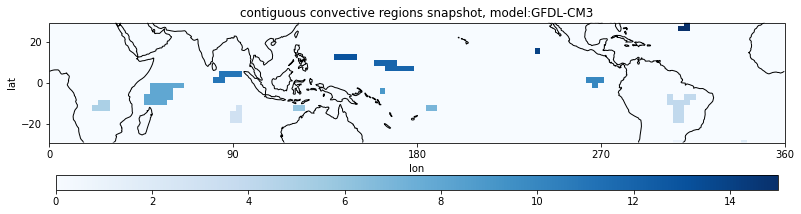

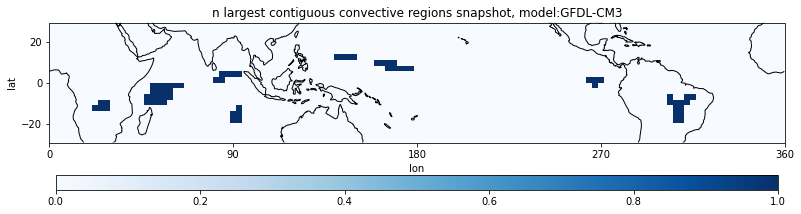

In [56]:
# check plot
L_n = np.sum(np.stack([(L==label) for label in labels_n],axis=2)*1, axis=2)
Ln_xr = xr.DataArray(
    data=L_n,
    dims=['lat', 'lon'],
    coords={'lat': pr_day.lat.data, 'lon': pr_day.lon.data}
    )

myPlots.plot_snapshot(L_xr, 'Blues', 'contiguous convective regions', model)
myPlots.plot_snapshot(Ln_xr, 'Blues', 'n largest contiguous convective regions', model)

In [60]:
# calculating one scene using function from rome_Scene
def rome_nScene(n, o_areaScene, L, labels, lat, lon, aream, latm3d, lonm3d):

    if len(o_areaScene) <= n:
        labels_n = labels
    else:
        labels_n = labels[o_areaScene.argsort()[-n:]]

    return rome_scene(L, labels_n, lat, lon, aream, latm3d, lonm3d)
    

In [99]:
# for multiple scenes
def calc_rome_n(n, precip, listOfdays, conv_threshold): 
    rome_n = []

    lat = precip.lat.data
    lon = precip.lon.data
    lonm,latm = np.meshgrid(lon,lat)
    dlat = (lat[1]-lat[0])
    dlon = (lon[1]-lon[0])
    R = 6371
    aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

    latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
    lonm3d = np.expand_dims(lonm,axis=2)
    aream3d = np.expand_dims(aream,axis=2)

    for day in listOfdays:
        pr_day = precip.isel(time=day)
        
        L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2)
        myFuncs.connect_boundary(L)
        labels = np.unique(L)[1:]

        obj3d = np.stack([(L==label) for label in labels],axis=2)*1
        o_areaScene = np.sum(obj3d * aream3d, axis=(0,1))

        rome_n = np.append(rome_n, rome_nScene(n, o_areaScene, L, labels, lat, lon, aream, latm3d, lonm3d))
    

    rome_n = xr.DataArray(
        data=rome_n,
        dims=['time'],
        coords={'time': precip.time.data[0:len(listOfdays)]},
        attrs={'description':'rome calculated from {} largest contigiuos convetive areas'.format(n),
        'units': 'km^2'}
        )

    return rome_n


In [100]:
# calling on data array
precip = ds.pr4_days
listOfdays = np.arange(0,len(ds.pr4_days.time))

rome_n = calc_rome_n(n, precip, listOfdays, conv_threshold)

## testing on artificial fields

In [101]:
artScenes = xr.zeros_like(ds.pr4_days) # shape = (4, 22, 128)

In [102]:
artScenes

<xarray.DataArray 'pr4_days' (time: 4, lat: 22, lon: 128)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1970-01-04 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:    mm/day

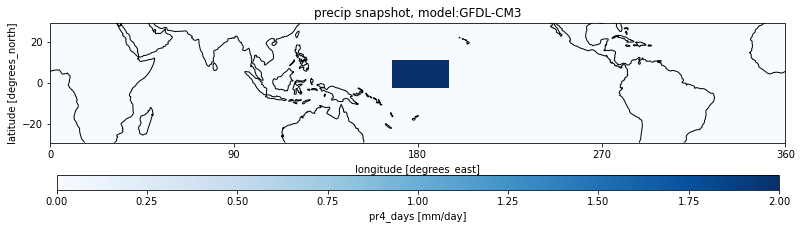

In [103]:
# only one object
artScenes[0, :, :] = 0
artScenes[0, 10:15, 60:70] = 2

myPlots.plot_snapshot(artScenes.isel(time=0), 'Blues', 'precip', model)

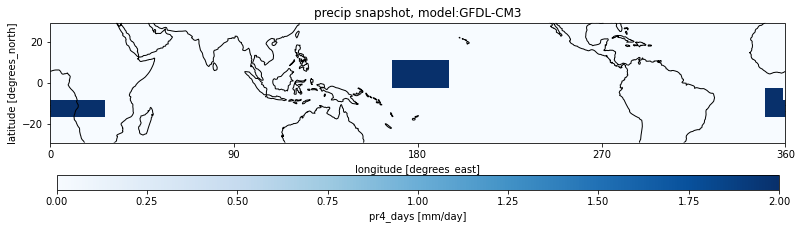

In [116]:
# two objects (across boundary)
artScenes[1, :, :] = 0
artScenes[1, 10:15, 60:70] = 2

artScenes[1, 5:8, 0:10] = 2
artScenes[1, 5:10, 125:] = 2

myPlots.plot_snapshot(artScenes.isel(time=1), 'Blues', 'precip', model)

In [120]:
# testing that connect_boundary function recognizes that there are only two objects
pr_day = artScenes.isel(time=1)
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2)
print('labels before connecting boundary',np.unique(L))
myFuncs.connect_boundary(L)
labels = np.unique(L)[1:]
print('labels after connecting boundary:', labels)

labels before connecting boundary [0 1 2 3]
labels after connecting boundary: [1 3]


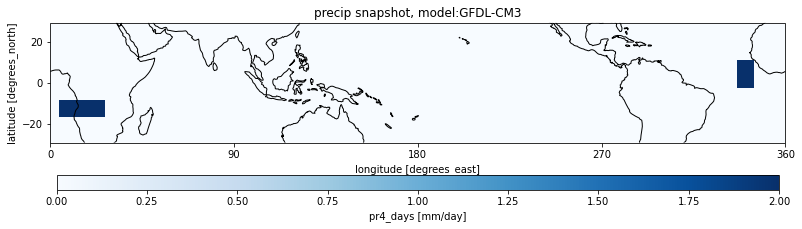

In [121]:
# two objects (across boundary is closer)
artScenes[2, :, :] = 0
artScenes[2, 5:8, 2:10] = 2

artScenes[2, 10:15, 120:-5] = 2

myPlots.plot_snapshot(artScenes.isel(time=2), 'Blues', 'precip', model)

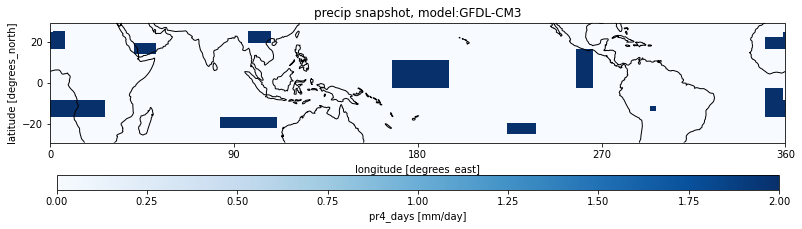

In [122]:
# multiple objects (including crossing boundary multiple times) (9 objects)
artScenes[3, :, :] = 0
artScenes[3, 10:15, 60:70] = 2

artScenes[3, 5:8, 0:10] = 2
artScenes[3, 5:10, 125:] = 2

artScenes[3, 17:20, 0:3] = 2
artScenes[3, 17:19, 125:] = 2

artScenes[3, 16:18, 15:19] = 2

artScenes[3, 3:5, 30:40] = 2

artScenes[3, 10:17, 92:95] = 2

artScenes[3, 6:7, 105:106] = 2

artScenes[3, 2:4, 80:85] = 2

artScenes[3, 18:20, 35:39] = 2

myPlots.plot_snapshot(artScenes.isel(time=3), 'Blues', 'precip', model)

In [124]:
# dimensions used for calculation
lat = artScenes.lat.data
lon = artScenes.lon.data
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
lonm3d = np.expand_dims(lonm,axis=2)
aream3d = np.expand_dims(aream,axis=2) # (usef later for n largest)
shape_L = np.shape(L)

In [22]:
precip = artScenes
listOfdays = np.arange(0,4)
conv_threshold = 1

calc_rome(precip, listOfdays, conv_threshold)

NameError: name 'artScenes' is not defined

In [130]:
calc_rome_n(n, precip, listOfdays, conv_threshold)

<xarray.DataArray ()>
array({'rome_n': array([4827671.79015079, 4902749.2222942 , 2568820.52722343,
       3017395.87200944])}, dtype=object)
Attributes:
    description:  rome calculated from 8 largest contigiuos convetive areas
    units:        km^2

## on larger dataset

### manually created

In [20]:
time_range = pd.date_range("1970/01/01","2000/01/01",freq='D', inclusive='left') # 30 years of daily data

pr_day = ds.pr4_days.isel(time=0)
pr_day = np.expand_dims(pr_day, axis=0)
array = np.ones(shape = (len(time_range), len(ds.pr4_days.lat), len(ds.pr4_days.lon)))
pr_big = array * pr_day 
np.shape(pr_big)

(10957, 22, 128)

In [21]:
pr_big = xr.DataArray(
                    data=pr_big,
                    dims=['time','lat', 'lon'],
                    coords={'time': time_range, 'lat': ds.pr4_days.lat.data, 'lon': ds.pr4_days.lon.data}
)

In [22]:
len(pr_big.time)

10957

In [24]:
listOfdays = np.arange(0,len(pr_big.time))
rome = aggFuncs.calc_rome(pr_big, listOfdays, conv_threshold)

In [77]:
len(rome)

10957

In [78]:
rome[1:5]

<xarray.DataArray (time: 4)>
array([739821.21121645, 739821.21121645, 739821.21121645, 739821.21121645])
Coordinates:
  * time     (time) datetime64[ns] 1970-01-02 1970-01-03 1970-01-04 1970-01-05
Attributes:
    units:    km^2

### from file

In [27]:
model = 'GFDL-CM3'
experiment = 'historical'
folder = '/Users/cbla0002/Documents/data/cmip5/' + model
fileName = model + '_precip_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)

In [28]:
ds

<xarray.Dataset>
Dimensions:  (time: 10950, lat: 22, lon: 128)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr       (time, lat, lon) float32 ...
Attributes:
    regrid_method:  conservative

In [32]:
precip = ds.pr*60*60*24
precip.attrs['units']= 'mm/day'
precip

<xarray.DataArray 'pr' (time: 10950, lat: 22, lon: 128)>
array([[[4.08858657e-01, 3.12826395e-01, 2.66478002e-01, ...,
         7.82788754e-01, 5.55889487e-01, 4.91493523e-01],
        [4.22117233e-01, 2.40650624e-01, 1.58740297e-01, ...,
         8.07168961e-01, 5.85888326e-01, 5.24520874e-01],
        [2.71370828e-01, 1.18661821e-01, 6.75984770e-02, ...,
         4.74144459e-01, 4.24919963e-01, 4.05480087e-01],
        ...,
        [1.90939274e-04, 2.30353166e-04, 4.63937467e-05, ...,
         0.00000000e+00, 2.78055512e-09, 2.02344672e-05],
        [1.62480981e-04, 5.49919961e-04, 2.26543372e-04, ...,
         4.59178806e-11, 3.44704154e-10, 2.20209113e-05],
        [1.87449245e-04, 8.20199493e-05, 4.61850832e-05, ...,
         4.66769282e-03, 5.29152434e-03, 3.79748479e-03]],

       [[5.20864546e-01, 5.28695166e-01, 4.83805656e-01, ...,
         5.20202994e-01, 4.44190621e-01, 4.29574966e-01],
        [4.38689321e-01, 4.05646205e-01, 2.81971216e-01, ...,
         4.92263496e-01, 3.51503998e-01, 3.77124488e-01],
        [5.00151277e-01, 4.25230354e-01, 1.98965132e-01, ...,
         4.04337049e-01, 3.45240235e-01, 4.43055809e-01],
...
        [5.59766899e-09, 2.99688229e-32, 0.00000000e+00, ...,
         2.86355467e-10, 7.04136927e-09, 1.71255028e-08],
        [4.88535523e-09, 1.17072363e-09, 8.21280643e-09, ...,
         5.12836152e-07, 5.82156972e-08, 3.00863725e-08],
        [1.89105576e-05, 2.66464149e-08, 4.29197513e-08, ...,
         2.21278742e-02, 2.44675390e-02, 2.96266121e-03]],

       [[2.66608298e-01, 2.07568243e-01, 2.14525402e-01, ...,
         1.79786175e-01, 2.77063102e-01, 3.14550877e-01],
        [3.14109057e-01, 3.18816870e-01, 2.46779546e-01, ...,
         3.24843109e-01, 3.32155108e-01, 2.67388195e-01],
        [4.73636806e-01, 4.05086994e-01, 3.10137302e-01, ...,
         2.16585651e-01, 3.06336045e-01, 4.47086453e-01],
        ...,
        [1.05024958e-02, 5.50237438e-03, 3.46267416e-06, ...,
         1.23978796e-04, 9.12268995e-04, 3.50002619e-03],
        [8.40858263e-07, 4.97356996e-06, 1.98428370e-06, ...,
         3.36105913e-05, 9.05447791e-07, 2.45206934e-07],
        [6.08904869e-04, 9.31636605e-05, 4.13278076e-06, ...,
         7.81251043e-02, 1.14151299e-01, 3.18472683e-02]]], dtype=float32)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:    mm/day

In [33]:
listOfdays = np.arange(0,len(precip.time))
conv_threshold = 17.88
rome = aggFuncs.calc_rome(precip, listOfdays, conv_threshold)

In [34]:
type(rome)

xarray.core.dataarray.DataArray

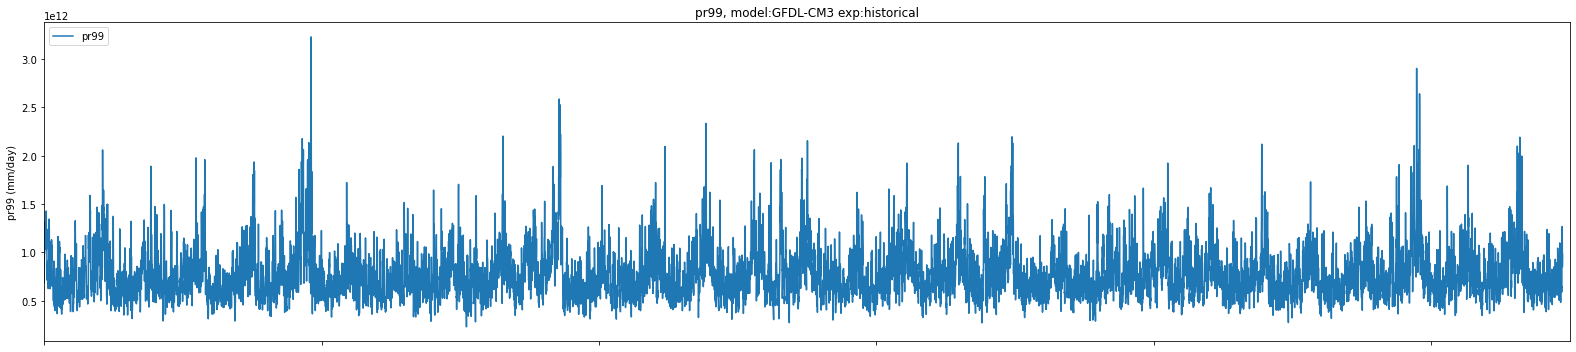

In [56]:
f, ax = plt.subplots(figsize=(22, 5))

da = xr.DataArray(rome.data*1e6)
da.plot(ax=ax, label='pr99', add_legend=True)
ax.set_title('pr99, model:' + model + ' exp:' + experiment)
ax.set_ylabel('pr99 (mm/day)')
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_xlim(0, 11000)
ax.legend(loc = 'upper left')

plt.tight_layout()

In [5]:
from scipy.io import loadmat
data = loadmat('/Users/cbla0002/Documents/other/data_matlab/97th_percentile/aggregation_index/NOAA-GFDL_aggregation_index_historical.mat')
print(data.keys())
rome_matlab = np.squeeze(data['ROME'])
f, ax = plt.subplots(figsize=(22, 5))

da = xr.DataArray(rome_matlab)
da.plot(ax=ax, label='pr99', add_legend=True)
ax.set_title('pr99, model:' + model + ' exp:' + experiment)
ax.set_ylabel('pr99 (mm/day)')
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_xlim(0, 11000)
ax.legend(loc = 'upper left')

plt.tight_layout()

dict_keys(['__header__', '__version__', '__globals__', 'COP', 'COP_n', 'Number_index', 'Number_index_n', 'ROME', 'ROME_n', 'SCAI', 'SCAI_n'])


AttributeError: module 'matplotlib' has no attribute 'subplots'

## saving

In [ ]:
# check that compressed file is the same as uncompressed
# tas.identical(xarray.open_dataset('tas_compressed.nc').tas)




